# 프로젝트명 : SRGAN 활용하기

|No.|평가문항|상세기준|
|:---|:---|:---|
|1|SRGAN을 이용해 고해상도의 이미지를 생성하였다.|SRGAN을 통해 생성된 이미지를 제출하였다.|
|2|다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.|이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.|
|3|저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.|저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.|

In [30]:
import os
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf

## Super Resolution

이미지 크기: (448, 680, 3)


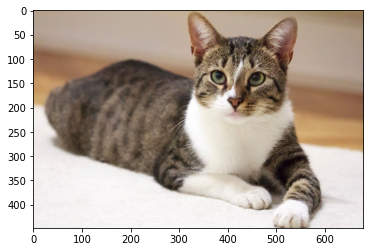

In [31]:
img_path = os.getenv('HOME') + '/aiffel/exploration/E16/data/cat.jpg'
hr_image = cv2.imread(img_path)
print("이미지 크기:", hr_image.shape)

hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
plt.imshow(hr_image)

plt.show()

(150, 230, 3)


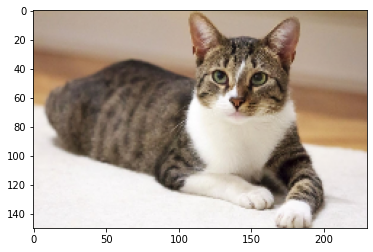

In [32]:
lr_image = cv2.resize(hr_image, dsize=(230,150)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)
plt.imshow(lr_image)

plt.show()

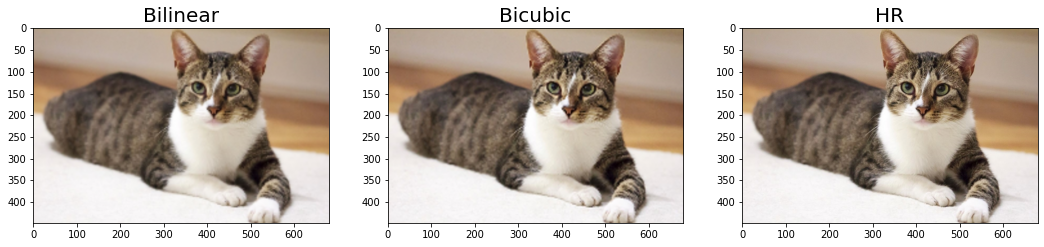

In [33]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=(680, 448), 
    interpolation=cv2.INTER_LINEAR
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(680, 448), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(18,6))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

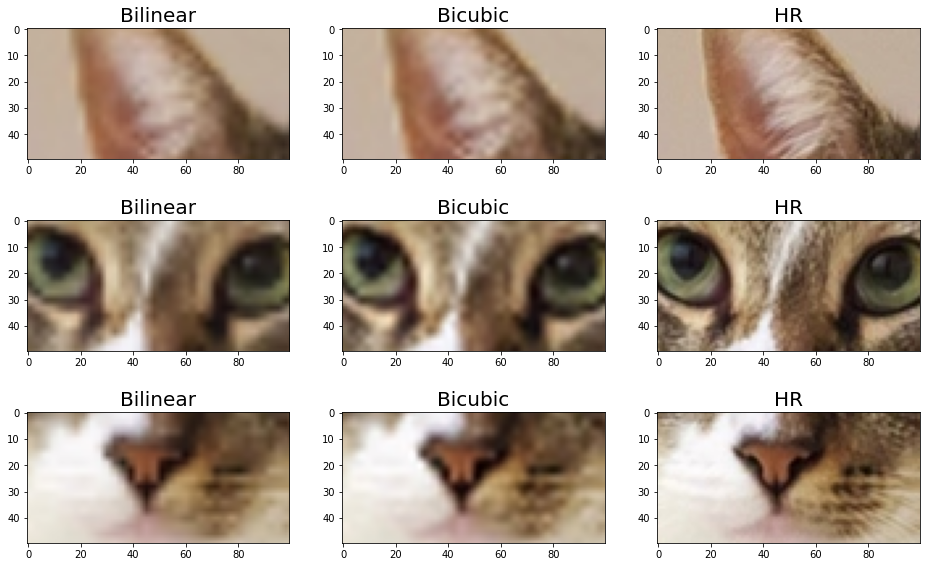

In [34]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(20,300)] *3 + [(120,370)] *3 + [(170,370)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

## SRGAN

### generator

![img01](https://d3s0tskafalll9.cloudfront.net/media/images/e-22-17.srgan_gene.max-800x600.png)

In [35]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림 뒤쪽의 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)

# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

### discriminator

![img02](https://d3s0tskafalll9.cloudfront.net/media/images/e-22-18.srgan_disc.max-800x600.png)

In [36]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
        
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

In [37]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

## 프로젝트 1-1

__1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.__

이미지 크기: (448, 680, 3)


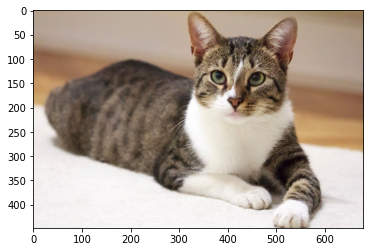

In [38]:
img_path = os.getenv('HOME') + '/aiffel/exploration/E16/data/cat.jpg'
hr_image = cv2.imread(img_path)
print("이미지 크기:", hr_image.shape)

hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
plt.imshow(hr_image)

plt.show()

__2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. `cv2.resize()`를 사용해 봅시다.__

(112, 170, 3)


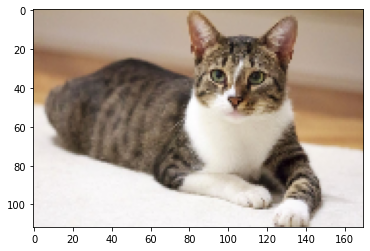

In [39]:
lr_image = cv2.resize(hr_image, dsize=(170,112)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)
plt.imshow(lr_image)

plt.show()

__3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.__

In [40]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np

# 이미 학습이 완료된 SRGAN generator를 이용하여 학습이 완료된 모델을 불러옵니다.
model_file = os.getenv('HOME') + '/aiffel/exploration/E16/data/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [41]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(lr_image)

__4. 2번의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.__

In [42]:
bicubic_image = cv2.resize(lr_image, 
                           dsize=(680, 448), 
                           interpolation=cv2.INTER_CUBIC
                          )

__5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.__

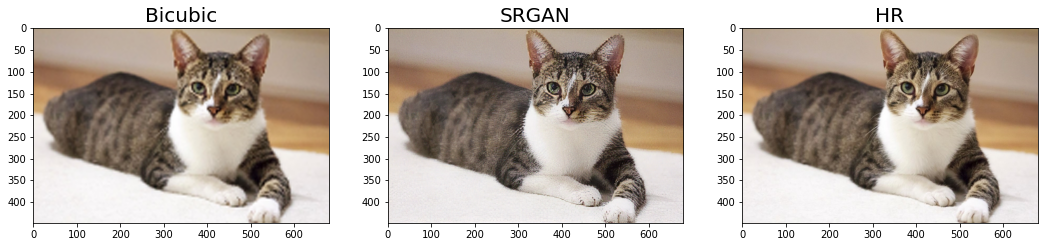

In [43]:
images = [bicubic_image, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(18,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

__6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다.__

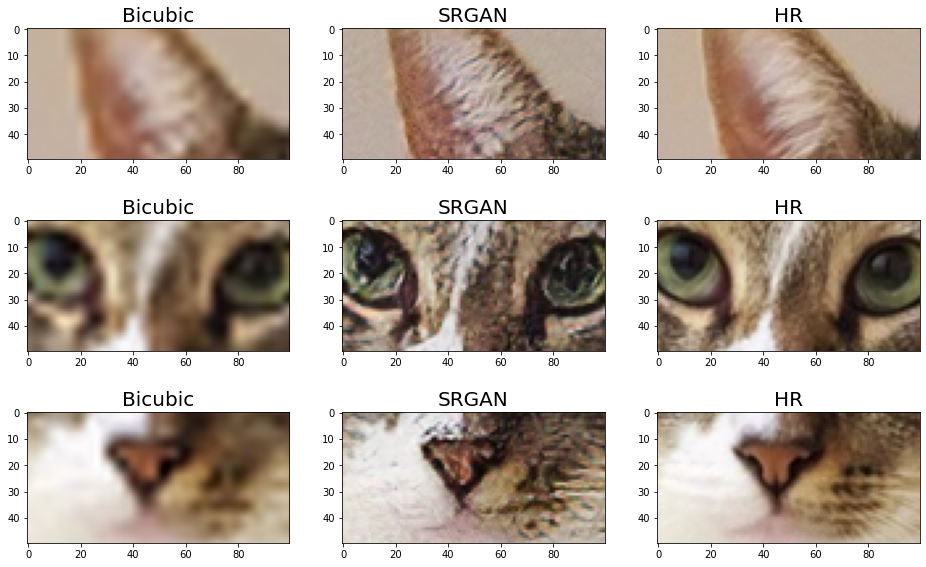

In [44]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(20,300)] *3 + [(120,370)] *3 + [(170,370)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

고해상도 이미지를 저해상도 만든 뒤 다시 고해상도로 변환해줬을 때, Bicubic Interpolation은 이미지가 뿌옇게 나왔고, SRGAN은 Bicubic Interpolation 보다 훨씬 설명했으나, HR 이미지의 선명함과 비교했을 때 사진 느낌이 아닌 하나의 그림 같이 상대적으로 명암, 질감의 터치가 또렷해 보였다.  
SRGAN은 이미지 생성 시 생성자가 이미지를 위조해서 만들어내기 때문에 이미지의 특정 부분의 확대해서 보았을때 조금 부자연 스러운 부분이 나타나는 것이 아닐까 생각된다.

## 프로젝트 1-2

__1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.__

이미지 크기: (320, 240, 3)


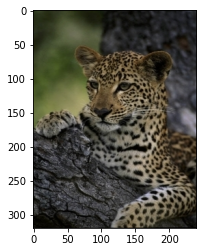

In [45]:
img_path = os.getenv('HOME') + '/aiffel/exploration/E16/data/lion.jpg'
lr_image = cv2.imread(img_path)
print("이미지 크기:", lr_image.shape)

lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
plt.imshow(lr_image)

plt.show()

__2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.__

In [46]:
# 고해상도 이미지 생성
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(lr_image)

__3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.__

In [47]:
bicubic_hr = cv2.resize(lr_image, 
                           dsize=(240*4, 320*4), 
                           interpolation=cv2.INTER_CUBIC
                          )

__4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.__

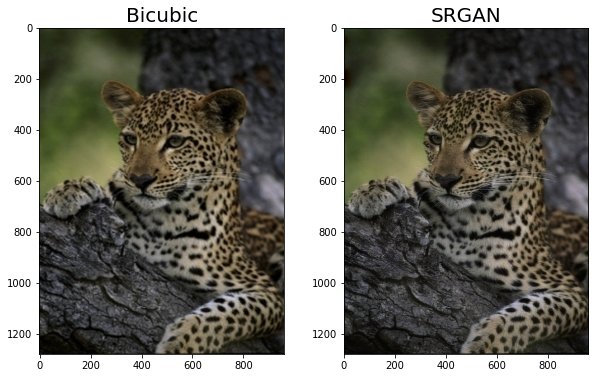

In [48]:
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(10,6))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

__5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다.__

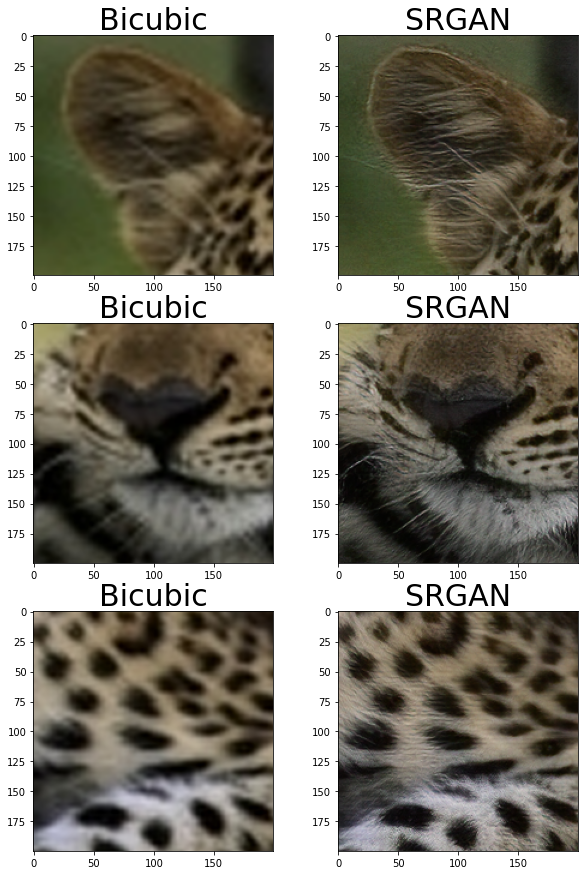

In [49]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,220), (530,300), (900,650)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(10,15))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

저해상도 이미지를 고해상도로 만들었을 때 사진의 특정 범위를 확대해서 보면, Bicubic Interpolation은 전반적으로 흐릿한 형태의 이미지가 만들어졌고, SRGAN은 좀 더 선명하고 사실적으로 보인다. 이는 예제 노드에서 학습한 것처럼 VGG구조를 이용한 content loss를 통해 학습한 것 또한 사실적인 이미지를 형성하는데 크게 기여했기 때문일 것이다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

In [50]:
# $ pip install imageio

### 1. gif 파일 불러오기

In [51]:
import cv2
import os

gif_path = os.getenv('HOME') + '/aiffel/exploration/E16/data'
gif = cv2.VideoCapture(os.path.join(gif_path, 'city_night_lr.gif'))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


### 2. 프레임별 Super Resolution 진행하기

Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.

In [52]:
# Bicubic interpolation
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(frame,
                                       dsize=(frame.shape[1]*4, frame.shape[0]*4),
                                       interpolation=cv2.INTER_CUBIC
                                       ))

In [53]:
# SRGAN
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

frames_sr_srgan = []

for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

### 3. 프레임을 합쳐 gif 만들기

In [54]:
import imageio

imageio.mimsave(os.path.join(gif_path, 'city_night_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'city_night_hr_srgan.gif'), frames_sr_srgan)

### 4. Jupyter notebook에 gif 표시하기

In [62]:
from IPython.display import Image as show_gif

In [ ]:
show_gif(os.path.join(gif_path, 'city_night_lr.gif'), width=800) # width 는 적당히 큰 값으로 설정해주세요

### lr.gif

<img src='http://drive.google.com/uc?export=view&id=1s7skwQKKXolb6E2yEXpsmJ4fM079XWEJ' /><br>

In [ ]:
show_gif(os.path.join(gif_path, 'city_night_bicubic.gif'), width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

### Bicubic.gif

<img src='http://drive.google.com/uc?export=view&id=1iF8Hn_WmQoISqm_lCSibjYNrVzJa6TXI' /><br>

In [ ]:
show_gif(os.path.join(gif_path, 'city_night_srgan.gif'), width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

### SRGAN.gif

<img src='http://drive.google.com/uc?export=view&id=1arOQPCDrpRx9EfW5LzzJf-6GP19xWPJb' /><br>

생성된 이미지를 열어서 모니터로 확인해보니 위에 프로젝트와 마찬가지로 SRGAN의 이미지가 상대적으로 조금 더 선명하고 짙은 질감을 주는 느낌의 이미지를 만들어내는 것을 확인할 수 있었다.

## 회고

- 우선 역대급으로 친절하고 자세한 설명이 되어 있는 노드여서 정말 재미있게 진행할 수 있는 노드였다. 덕분에 프로젝트도 수월하게 진행되었다.  
  
    
- 노드 초반 부에 나와 있는 드라마 하얀거탑의 리마스터링 작품이 나왔다는 사실은 뉴스를 통해서 알고 있었는데 그 방법이 Super resolution 기법을 적용한 방법인지는 모르고 있다가 이번에 알게되었다. 단순히 간단한 사진 뿐만 아니라 영상까지 이러한 기법이 적용되어 화잘을 높여줄 수 있다는 사실이 매우 놀라웠다.  


- 어플 카메라로 찍은 사진들이 기본 카메라에 비해 상대적으로 해상도가 떨어지는 경우가 있는데, 추가적으로 이러한 사진들을 이용해 고해상도로 만들 수 있는지 테스트 해보고 싶다.